# Test Caputo Integration

In [2]:
from caputo import caputo_euler
from math import gamma
from matplotlib import pyplot as plt
import numpy as np

In [11]:
# Test constant
alpha = 0.5
t0 = 0
tf = 1
num_step = 1000
y0 = 1

f = lambda t, y: 0

ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)

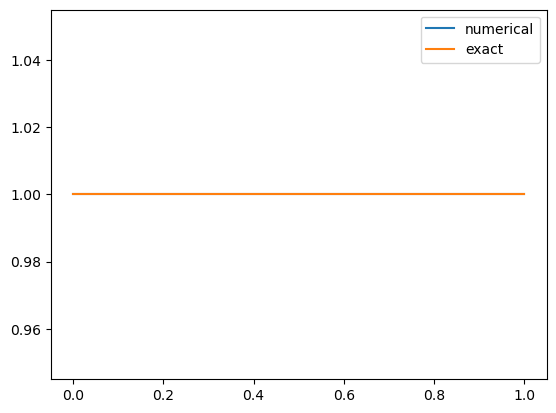

In [12]:
fig, ax = plt.subplots()
ax.plot(ts, ys, label='numerical')
ax.plot(ts, y0 * np.ones(ts.size), label='exact')
ax.legend()

In [5]:
# Test power of a function
alpha = 0.6
b = 3
t0 = 0
tf = 1
num_step = 1000
y0 = 0

f = lambda t, y, alpha=alpha, b=b: gamma(b + 1) / gamma(b - alpha + 1) * (t ** (b - alpha) - t0 ** (b - alpha))

ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)

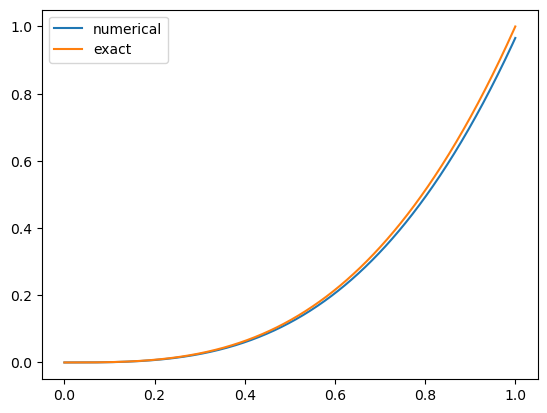

In [6]:
fig, ax = plt.subplots()
ax.plot(ts, ys, label='numerical')
ax.plot(ts, ts ** b, label='exact')
ax.legend()

In [40]:
# Error convergence study
alpha = 0.5
b = 3
t0 = 0
tf = 1
num_steps = [500, 1000, 2000, 4000, 8000]
errs = []
y0 = 0

f = lambda t, y, alpha=alpha, b=b: gamma(b + 1) / gamma(b - alpha + 1) * (t ** (b - alpha) - t0 ** (b - alpha))

for num_step in num_steps:
    ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)
    errs.append(abs(ys[-1] - 1))

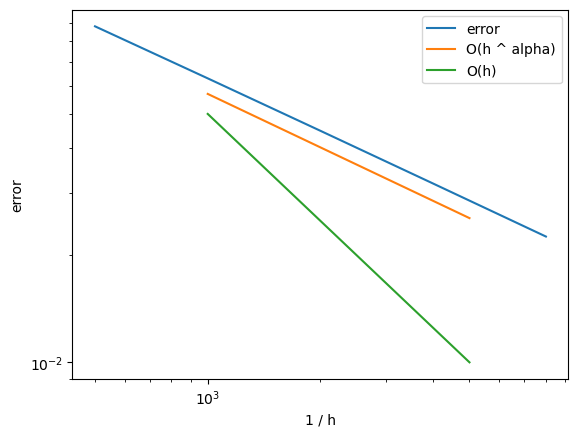

In [41]:
fig, ax = plt.subplots()
ns = np.linspace(1000, 5000, 11)
ax.loglog(num_steps, errs, label='error')
ax.loglog(ns, [1.8 / n ** alpha for n in ns], label='O(h ^ alpha)')
ax.loglog(ns, [50 / n for n in ns], label='O(h)')
ax.set_xlabel('1 / h')
ax.set_ylabel('error')
ax.legend()

In [33]:
# Try SEIRD model
alpha = 0.9
beta = 0.25
sigma = 0.13
gam = 0.052
mu = 0.005
t0 = 0
tf = 500
num_step = 100
y0 = np.array([0.99, 0.01, 0, 0, 0])

f = lambda t, y: np.array([
    - beta * (y[0] * y[3]) / (1 - y[4]),
    beta * (y[0] * y[3]) / (1 - y[4]) - sigma * y[1],
    sigma * y[1] - (gam + mu) * y[2],
    gam * y[2],
    mu * y[2]
])

ts, ys = caputo_euler(f, alpha, (t0, tf), num_step, y0)

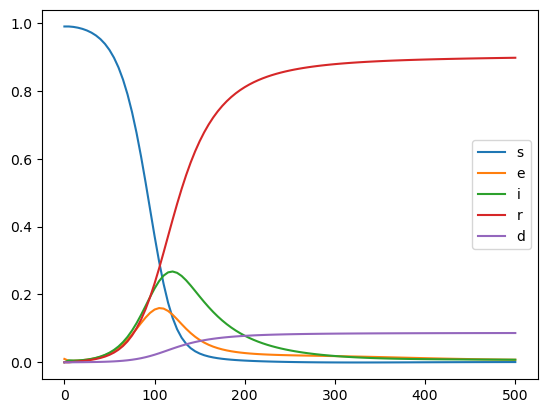

In [34]:
fig, ax = plt.subplots()
ax.plot(ts, ys[:, 0], label='s')
ax.plot(ts, ys[:, 1], label='e')
ax.plot(ts, ys[:, 2], label='i')
ax.plot(ts, ys[:, 3], label='r')
ax.plot(ts, ys[:, 4], label='d')
ax.legend()